<a href="https://colab.research.google.com/github/Rootmode/Deep_Learning_Projects/blob/main/Gan_CelebA_Face_%C4%B0mage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Drive and zip file setting

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!unzip '/content/drive/MyDrive/Celeba/img_align_celeba.zip'

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 ex

#İmport Libary and Device Setting

In [12]:
import time
import os
import numpy as np
import torch
import random
from platform import python_version

import torch.nn.functional as F
import torch.nn as nn
import torchvision.utils as vutils

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [13]:
#Matplot device setting
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
##########################
### SETTINGS
##########################

# Device
CUDA = 'cuda:0'
DEVICE = torch.device(CUDA if torch.cuda.is_available() else "cpu")#Colab GPU KULLANILACAK

# Device
CUDA = 'cuda:0'
DEVICE = torch.device(CUDA if torch.cuda.is_available() else "cpu")#CPU ile calışıldığı için cpu 0 secilidi

RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002
NUM_EPOCHS = 15
BATCH_SIZE = 128
NUM_WORKERS = 2 # workers for data loader

IMAGE_SIZE = (64, 64, 3)

# Size of the latent vector
LATENT_DIM = 100

# Number of feature maps in generator and discriminator
NUM_MAPS_GEN = 64
NUM_MAPS_DIS = 64

# Set random seeds for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);

In [15]:
#Version and cpu check
print('Device kullanım bilgisi :',DEVICE)
print('Torch Versiyon          :' ,torch.__version__)
print('Pyhton Version          :', python_version())

Device kullanım bilgisi : cuda:0
Torch Versiyon          : 1.11.0+cu113
Pyhton Version          : 3.7.13


#Simple Virsulation

(218, 178, 3)


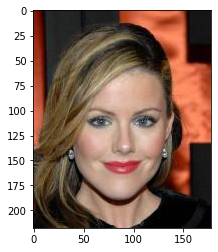

In [17]:
img = Image.open(os.path.join('/content/img_align_celeba/000042.jpg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

#Dataloader and dataset set setting

In [35]:
#DataLoader Class Create
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, img_dir, transform=None):
    
        self.img_dir = img_dir
        
        self.img_names = [i for i in 
                          os.listdir(img_dir) 
                          if i.endswith('.jpg')]

        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img

    def __len__(self):
        return len(self.img_names)

In [36]:
#Dataset  Traindataset  and trainloader setting
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomRotation(5),
        #transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(IMAGE_SIZE[0], scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        # normalize images to [-1, 1] range
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'valid': transforms.Compose([
        transforms.Resize([IMAGE_SIZE[0], IMAGE_SIZE[1]]),
        transforms.ToTensor(),
        # normalize images to [-1, 1] range
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}


train_dataset = CelebaDataset(img_dir=os.path.join('/content/img_align_celeba'), 
                                transform=data_transforms['train'])

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          num_workers=2,
                          shuffle=True)

train_loader

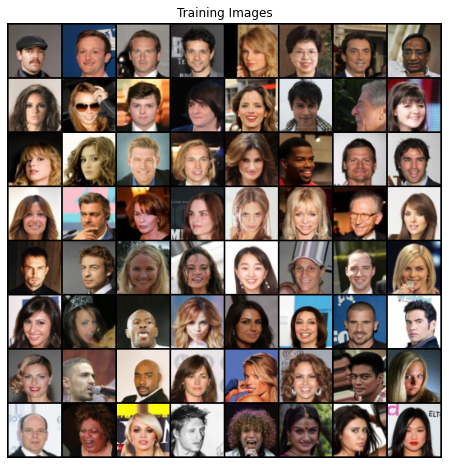

In [37]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8 ))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64], 
                                         padding=2, normalize=True),
                        (1, 2, 0)))

#Model Setting and create Model

In [62]:
def weights_init(module):
    """
    Function that initializes weights according to
    Radford et al.'s DCGAN paper
    """
    classname = module.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(module.weight.data, 1.0, 0.02)
        nn.init.constant_(module.bias.data, 0)

In [61]:
##########################
### MODEL
##########################

class DCGAN(torch.nn.Module):

    def __init__(self):
        super(DCGAN, self).__init__()
        
        
        self.generator = nn.Sequential(
            #
            # input size: vector z of size LATENT_DIM
            #
            nn.ConvTranspose2d(LATENT_DIM, NUM_MAPS_GEN*8, 
                               kernel_size=4, stride=1, padding=0,
                               bias=False), # bias is redundant when using BatchNorm
            nn.BatchNorm2d(NUM_MAPS_GEN*8),
            nn.ReLU(True),
            #
            # size: NUM_MAPS_GEN*8 x 4 x 4
            #
            nn.ConvTranspose2d(NUM_MAPS_GEN*8, NUM_MAPS_GEN*4, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(NUM_MAPS_GEN*4),
            nn.ReLU(True),
            #
            # size: NUM_MAPS_GEN*4 x 8 x 8
            #
            nn.ConvTranspose2d(NUM_MAPS_GEN*4, NUM_MAPS_GEN*2, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(NUM_MAPS_GEN*2),
            nn.ReLU(True),
            #
            # size: NUM_MAPS_GEN*2 x 16 x 16
            #
            nn.ConvTranspose2d(NUM_MAPS_GEN*2, NUM_MAPS_GEN, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(NUM_MAPS_GEN),
            nn.ReLU(True),   
            #
            # size: NUM_MAPS_GEN x 32 x 32
            #
            nn.ConvTranspose2d(NUM_MAPS_GEN, IMAGE_SIZE[2], 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            #
            # size: IMAGE_SIZE[2] x 64 x 64
            #  
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            #
            # input size IMAGE_SIZE[2] x IMAGE_SIZE[0] x IMAGE_SIZE[1]
            #
            nn.Conv2d(IMAGE_SIZE[2], NUM_MAPS_DIS,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: NUM_MAPS_DIS x 32 x 32
            #              
            nn.Conv2d(NUM_MAPS_DIS, NUM_MAPS_DIS*2,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(NUM_MAPS_DIS*2),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: NUM_MAPS_DIS*2 x 16 x 16
            #   
            nn.Conv2d(NUM_MAPS_DIS*2, NUM_MAPS_DIS*4,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(NUM_MAPS_DIS*4),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: NUM_MAPS_DIS*4 x 8 x 8
            #   
            nn.Conv2d(NUM_MAPS_DIS*4, NUM_MAPS_DIS*8,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(NUM_MAPS_DIS*8),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: NUM_MAPS_DIS*8 x 4 x 4
            #   
            nn.Conv2d(NUM_MAPS_DIS*8, 1,
                      kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = model.discriminator(img)
        return pred

In [69]:
#Model Summary
torch.manual_seed(RANDOM_SEED)

loss_function = nn.BCELoss().float()

real_label = 1
fake_label = 0

# Batch of latent (noise) vectors for
# evaluating / visualizing the training progress
# of the generator
fixed_noise = torch.randn(64, LATENT_DIM, 1, 1, device=DEVICE)

model = DCGAN()
model = model.to(DEVICE)
model.apply(weights_init)

print(model)

DCGAN(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
 

In [70]:
from torchsummary import summary

# torchsummary can only use default cuda device, which
# causes issues if e.g., cuda:1 is used

with torch.cuda.device(int(CUDA.split(':')[-1])):
    summary(model.generator, input_size=(100, 1, 1), device='cuda')
    summary(model.discriminator, input_size=((IMAGE_SIZE[2], IMAGE_SIZE[0], IMAGE_SIZE[1])), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [71]:
#Optimazer setting
#iki ayrı sinir ağı olduğu için hem generater hemde optimazer için adam optimazer uygulanıyor
optim_gener = torch.optim.Adam(model.generator.parameters(),
                               betas=(0.5, 0.999),
                               lr=GENERATOR_LEARNING_RATE)
optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

#Traning Start

In [83]:

start_time = time.time()    

discr_costs = []
gener_costs = []
images_from_noise = []


for epoch in range(NUM_EPOCHS):
    model = model.train()
    for batch_idx, features in enumerate(train_loader):

        
        # --------------------------
        # Train Discriminator
        # --------------------------        
        
        optim_discr.zero_grad()
        
        real_images = features.to(DEVICE)
        num_real = real_images.size(0)
        real_label_vec = torch.full((num_real,), real_label, device=DEVICE).float()
      

        # get discriminator loss on real images
        discr_pred_real = model.discriminator_forward(real_images).view(-1).float()
      
        real_loss = loss_function(discr_pred_real, real_label_vec)
        #real_loss.backward()
        
        # get discriminator loss on fake images
        random_vec = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1, device=DEVICE).float()
        fake_images = model.generator_forward(random_vec)
        fake_label_vec = torch.full((num_real,), fake_label, device=DEVICE).float()
        discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
        fake_loss = loss_function(discr_pred_fake, fake_label_vec)
        #fake_loss.backward()        

        # combined loss
        discr_loss = 0.5*(real_loss + fake_loss)
        discr_loss.backward()

        optim_discr.step()        
  
        # --------------------------
        # Train Generator
        # --------------------------      

        optim_gener.zero_grad()        
        
        discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
        gener_loss = loss_function(discr_pred_fake, real_label_vec)
        gener_loss.backward()

        optim_gener.step()
        
        # --------------------------
        # Logging
        # --------------------------
        discr_costs.append(discr_loss.item())
        gener_costs.append(gener_loss.item())
        
        
        ### LOGGING
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), gener_loss, discr_loss))
            
    ### Save images for evaluation
    with torch.no_grad():
        fake_images = model.generator_forward(fixed_noise).detach().cpu()
        images_from_noise.append(
            vutils.make_grid(fake_images, padding=2, normalize=True))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/015 | Batch 000/1582 | Gen/Dis Loss: 2.6641/0.3673
Epoch: 001/015 | Batch 100/1582 | Gen/Dis Loss: 3.5736/0.4339
Epoch: 001/015 | Batch 200/1582 | Gen/Dis Loss: 3.2839/0.3501
Epoch: 001/015 | Batch 300/1582 | Gen/Dis Loss: 2.8537/0.2803
Epoch: 001/015 | Batch 400/1582 | Gen/Dis Loss: 1.8931/0.3970
Epoch: 001/015 | Batch 500/1582 | Gen/Dis Loss: 3.3108/0.4961
Epoch: 001/015 | Batch 600/1582 | Gen/Dis Loss: 1.2095/0.5950
Epoch: 001/015 | Batch 700/1582 | Gen/Dis Loss: 2.2091/0.2848
Epoch: 001/015 | Batch 800/1582 | Gen/Dis Loss: 1.9520/0.2776
Epoch: 001/015 | Batch 900/1582 | Gen/Dis Loss: 2.3885/0.3113
Epoch: 001/015 | Batch 1000/1582 | Gen/Dis Loss: 2.2542/0.2498
Epoch: 001/015 | Batch 1100/1582 | Gen/Dis Loss: 1.7128/0.3592
Epoch: 001/015 | Batch 1200/1582 | Gen/Dis Loss: 0.8860/0.5026
Epoch: 001/015 | Batch 1300/1582 | Gen/Dis Loss: 1.6564/0.3052
Epoch: 001/015 | Batch 1400/1582 | Gen/Dis Loss: 2.6520/0.3374
Epoch: 001/015 | Batch 1500/1582 | Gen/Dis Loss: 4.5937/0.9305
Ti

#generater and discrimeter loss

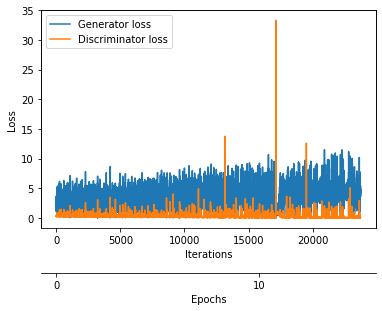

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt

ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(gener_costs)), gener_costs, label='Generator loss')
ax1.plot(range(len(discr_costs)), discr_costs, label='Discriminator loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()

###################
# Set scond x-axis
ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS+1))
iter_per_epoch = len(train_loader)
newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticklabels(newlabel[::10])
ax2.set_xticks(newpos[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())
###################

plt.show()

# VISUALIZATION

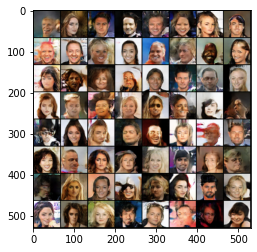

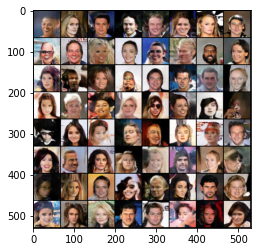

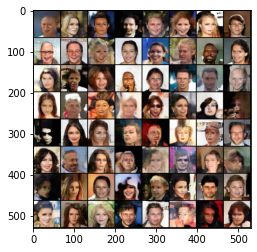

In [85]:
for i in range(0, NUM_EPOCHS, 5):
    plt.imshow(np.transpose(images_from_noise[i], (1, 2, 0)))
    plt.show()

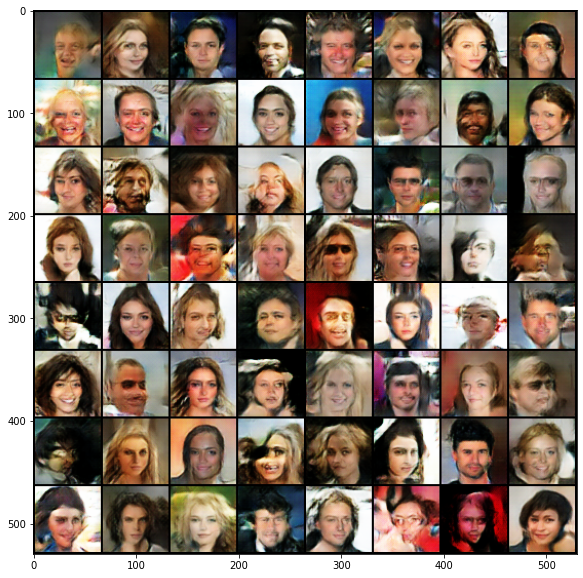

In [81]:
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(images_from_noise[-1], (1, 2, 0)))
plt.show()